## Env

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv')
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv')

display(train.head())
display(test.head())

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,134764,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,9854,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,94365,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,110641,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,100159,42.9,58.7,14.5,A,4,23,PL233,232,1564


,Id,X1,X2,X3,X4,X5,X6,X7,X8
0,0,158065,80.6,104.8,11.0,A,29,23,PL234
1,1,65927,141.8,34.2,17.5,A,2,91,PL911
2,2,117029,77.2,103.3,17.0,A,10,97,PL973
3,3,50866,95.5,131.0,18.0,A,2,23,PL234
4,4,151900,91.7,36.1,19.0,AH32,1,27,PL271


## Preprocessing

In [4]:
train = train.rename(columns = {
    'X1' : '작업번호',
    'X2' : '마킹길이',
    'X3' : '절단길이',
    'X4' : '철판두께',
    'X5' : '철판재질',
    'X6' : '절단갯수',
    'X7' : '작업장',
    'X8' : '작업자',
    'Y1' : '마킹시간',
    'Y2' : '절단시간'
})

test = test.rename(columns = {
    'X1' : '작업번호',
    'X2' : '마킹길이',
    'X3' : '절단길이',
    'X4' : '철판두께',
    'X5' : '철판재질',
    'X6' : '절단갯수',
    'X7' : '작업장',
    'X8' : '작업자'
})

In [5]:
train['철판재질'] = pd.factorize(train['철판재질'])[0]
train['작업자'] = pd.factorize(train['작업자'])[0]

test['철판재질'] = pd.factorize(test['철판재질'])[0]
test['작업자'] = pd.factorize(test['작업자'])[0]

In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   작업번호    121754 non-null  int64  
 1   마킹길이    121754 non-null  float64
 2   절단길이    121754 non-null  float64
 3   철판두께    121754 non-null  float64
 4   철판재질    121754 non-null  int64  
 5   절단갯수    121754 non-null  int64  
 6   작업장     121754 non-null  int64  
 7   작업자     121754 non-null  int64  
 8   마킹시간    121754 non-null  int64  
 9   절단시간    121754 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 9.3 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40571 entries, 0 to 40570
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      40571 non-null  int64  
 1   작업번호    40571 non-null  int64  
 2   마킹길이    40571 non-null  float64
 3   절단길이    40571 non-null  float64
 4   철판두께    40571 non-null  float64
 5   철판재질    40571 non-null  int64  
 6   절단갯수    40571 non-null  int64  
 7   작업장     40571 non-null  int64  
 8   작업자     40571 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.8 MB


None

In [7]:
display(train)

test.drop(columns = ['Id'], inplace = True)
display(test)

,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자,마킹시간,절단시간
0,134764,56.3,67.5,22.5,0,4,97,0,467,2241
1,9854,115.0,67.0,13.0,0,2,27,1,1058,1163
2,94365,59.2,44.6,18.0,1,1,14,2,270,1094
3,110641,52.1,97.4,15.0,2,17,24,3,391,2604
4,100159,42.9,58.7,14.5,2,4,23,4,232,1564
...,...,...,...,...,...,...,...,...,...,...
121749,147050,98.4,89.5,10.0,76,8,21,9,906,1226
121750,151590,48.0,51.0,23.0,77,1,23,18,175,1540
121751,152421,42.5,30.2,34.0,78,5,27,22,376,1492
121752,161172,22.1,15.3,36.0,64,8,97,0,85,723


,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자
0,158065,80.6,104.8,11.0,0,29,23,0
1,65927,141.8,34.2,17.5,0,2,91,1
2,117029,77.2,103.3,17.0,0,10,97,2
3,50866,95.5,131.0,18.0,0,2,23,0
4,151900,91.7,36.1,19.0,1,1,27,3
...,...,...,...,...,...,...,...,...
40566,112358,27.0,13.0,19.0,1,21,25,24
40567,150907,44.2,41.3,19.5,1,2,14,11
40568,57481,54.9,70.5,15.0,0,10,23,16
40569,48467,44.1,43.2,16.0,0,1,27,20


In [8]:
display(train.describe())
display(test.describe())

,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자,마킹시간,절단시간
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,81048.692675,77.608615,73.875636,17.444897,2.339816,13.630049,43.921152,13.363922,8.971671e+02,2193.206638
std,46870.157635,48.006125,53.267359,4.498316,4.120459,20.751914,32.509414,8.269139,4.604704e+04,2299.585390
min,1.000000,3.200000,1.800000,6.000000,0.000000,1.000000,14.000000,0.000000,0.000000e+00,0.000000
25%,40428.250000,45.200000,40.900000,14.500000,0.000000,1.000000,22.000000,6.000000,2.380000e+02,1064.000000
50%,81043.500000,68.100000,52.800000,17.000000,2.000000,4.000000,25.000000,12.000000,3.790000e+02,1593.000000
75%,121554.750000,98.300000,93.000000,20.000000,2.000000,18.000000,91.000000,21.000000,5.480000e+02,2778.000000
max,162341.000000,524.400000,621.300000,40.000000,78.000000,416.000000,97.000000,28.000000,6.157364e+06,348262.000000


,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자
count,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000
mean,81536.254122,78.408661,73.741996,17.488975,1.564837,13.451209,43.929161,12.575436
std,46845.236185,48.351212,53.069122,4.505772,3.556288,20.591742,32.503838,8.109459
min,4.000000,3.700000,1.100000,6.000000,0.000000,1.000000,14.000000,0.000000
25%,41100.500000,45.700000,41.000000,14.500000,0.000000,1.000000,22.000000,6.000000
50%,81500.000000,68.700000,52.500000,17.000000,1.000000,4.000000,25.000000,12.000000
75%,122412.500000,99.700000,92.700000,20.000000,1.000000,18.000000,91.000000,19.000000
max,162338.000000,445.300000,621.300000,36.000000,50.000000,262.000000,97.000000,28.000000


## EDA

<Axes: >

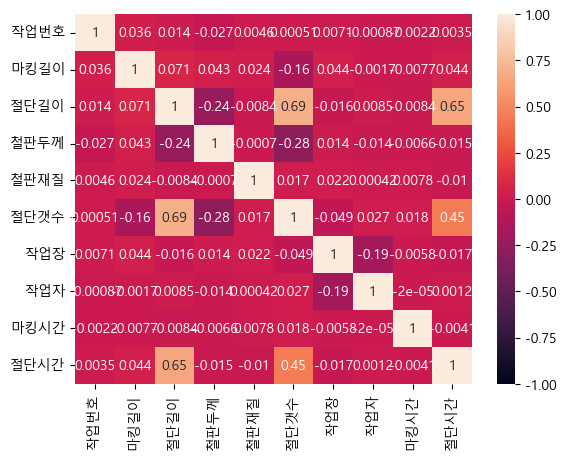

In [9]:
sns.heatmap(train.corr(), vmax = 1, vmin = -1, annot = True)

In [10]:
# sns.pairplot(train)

<Figure size 2000x2000 with 0 Axes>

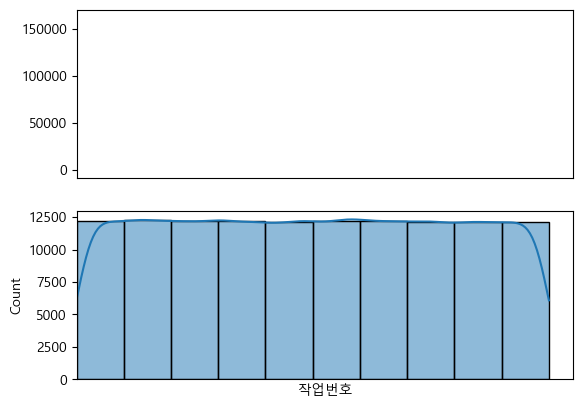

<Figure size 2000x2000 with 0 Axes>

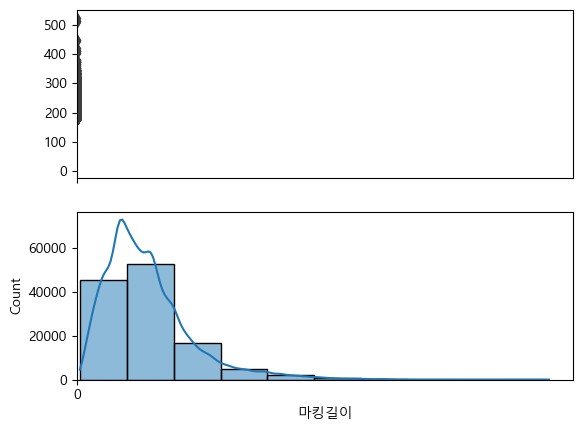

<Figure size 2000x2000 with 0 Axes>

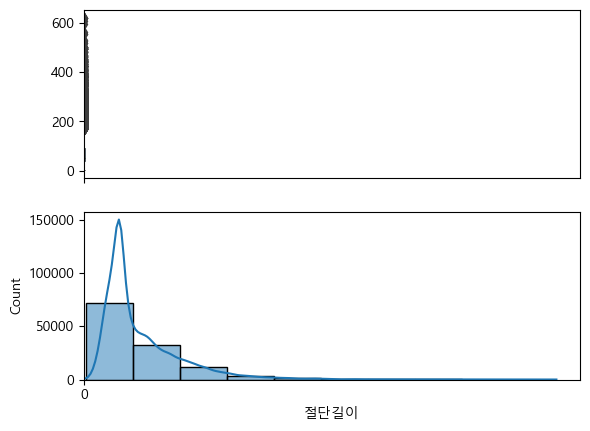

<Figure size 2000x2000 with 0 Axes>

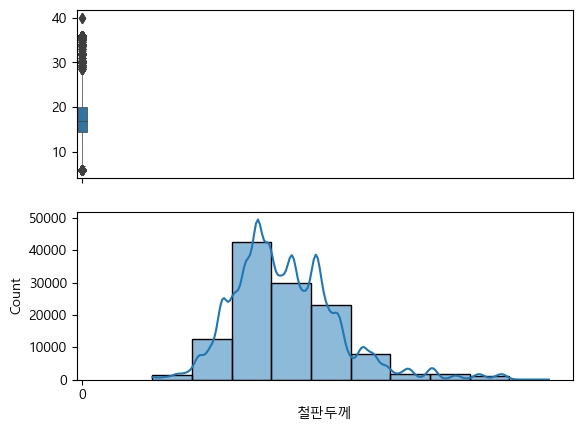

<Figure size 2000x2000 with 0 Axes>

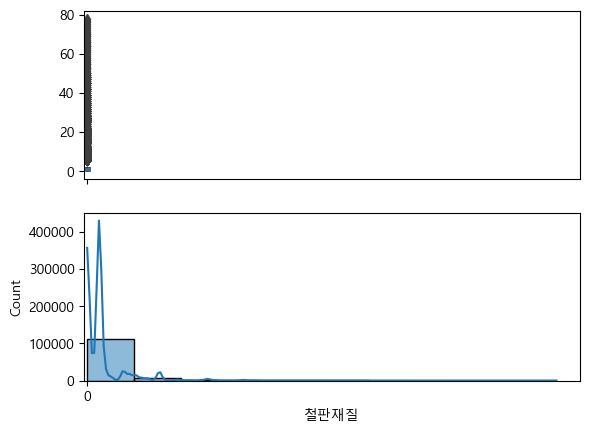

<Figure size 2000x2000 with 0 Axes>

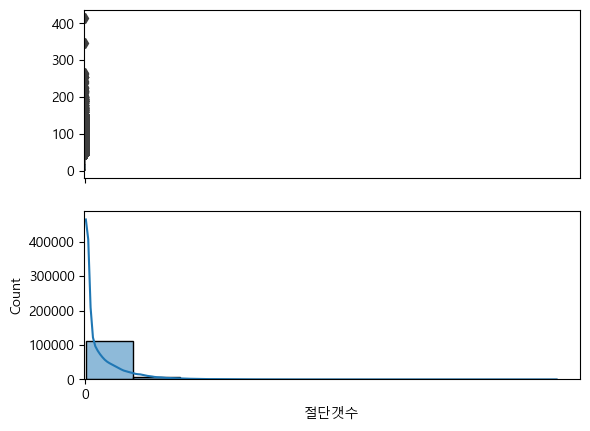

<Figure size 2000x2000 with 0 Axes>

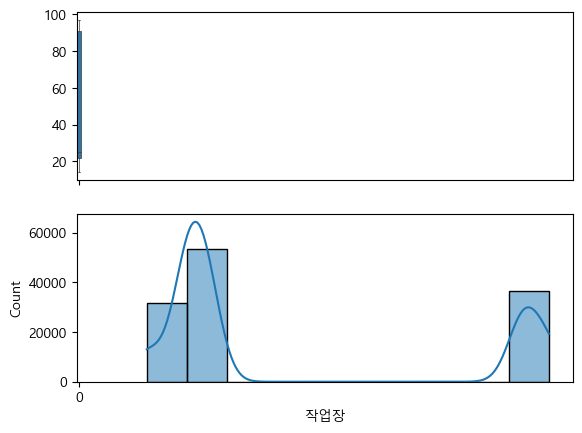

<Figure size 2000x2000 with 0 Axes>

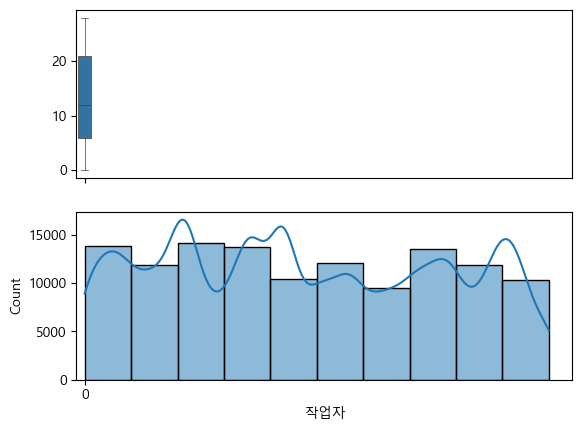

<Figure size 2000x2000 with 0 Axes>

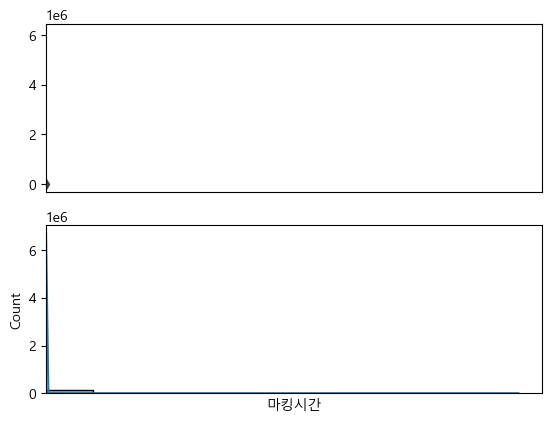

<Figure size 2000x2000 with 0 Axes>

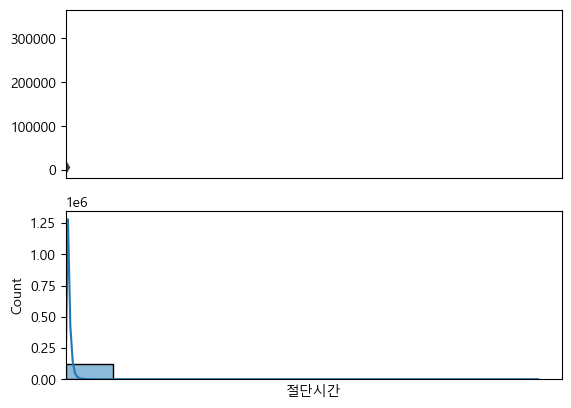

In [11]:
features = train.columns
numeric_features = train.select_dtypes('number').columns
categorical_features = train.select_dtypes('object').columns
for i in numeric_features:
  plt.figure(figsize = (20, 20))
  plt.tight_layout()
  f, (ax_box, ax_hist) = plt.subplots(2, sharex = True)
  sns.boxplot(train[i], ax = ax_box, linewidth = 0.5)
  sns.histplot(train[i], ax = ax_hist, bins = 10, kde = True)

c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


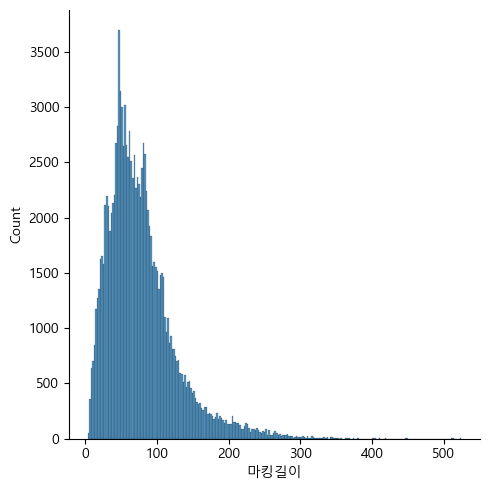

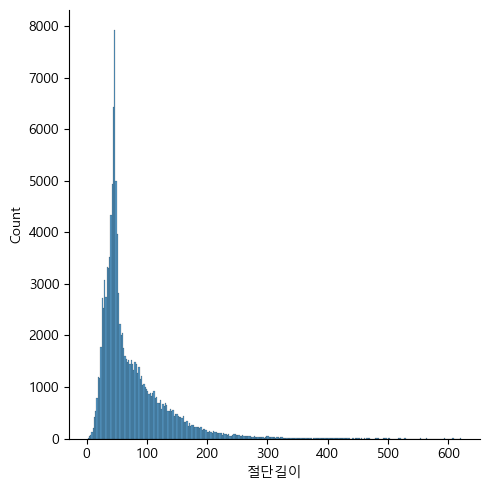

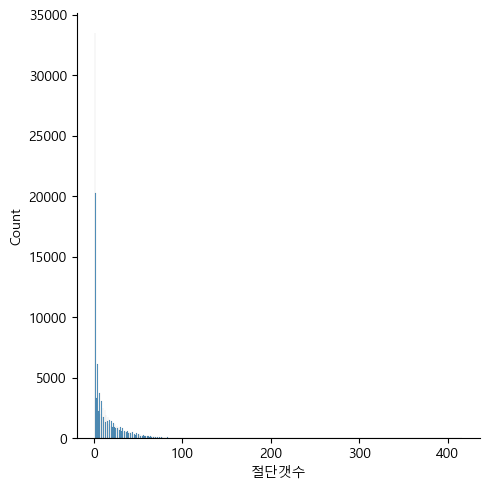

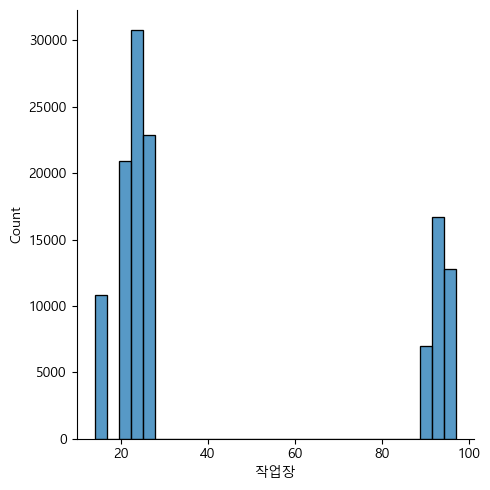

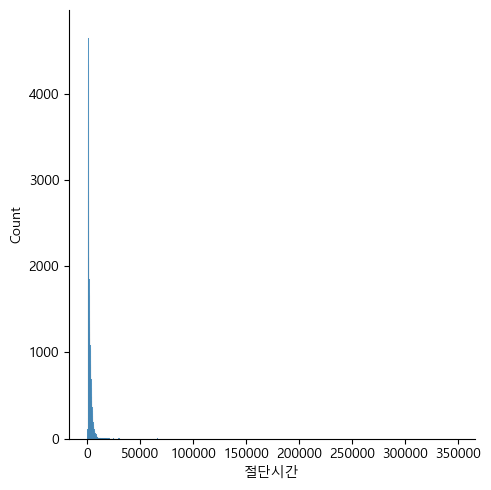

In [12]:
display(sns.displot(train['마킹길이']))
display(sns.displot(train['절단길이']))
display(sns.displot(train['절단갯수']))
display(sns.displot(train['작업장']))
display(sns.displot(train['절단시간']))

In [13]:
train['절단길이'] = np.log1p(train['절단길이'])
display(train['절단길이'].skew())

train['마킹길이'] = pd.Series(stats.boxcox(train['마킹길이'])[0])
display(train['마킹길이'].skew())

0.3131560106438574

0.008331940848424861

(array([1.8000e+01, 8.3000e+01, 4.9900e+02, 4.4170e+03, 2.5124e+04,
        4.6744e+04, 2.6536e+04, 1.4928e+04, 3.1220e+03, 2.8300e+02]),
 array([1.02961942, 1.5699997 , 2.11037999, 2.65076028, 3.19114057,
        3.73152085, 4.27190114, 4.81228143, 5.35266172, 5.893042  ,
        6.43342229]),
 <BarContainer object of 10 artists>)

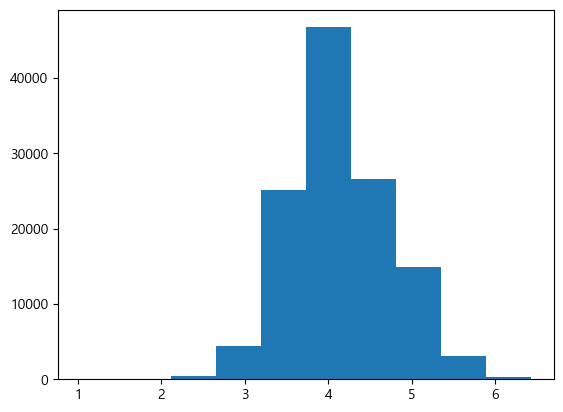

In [14]:
plt.hist(train['절단길이'])

(array([5.8400e+02, 3.6620e+03, 1.2080e+04, 2.7664e+04, 3.8799e+04,
        2.6089e+04, 9.1620e+03, 3.2750e+03, 4.2600e+02, 1.3000e+01]),
 array([ 1.35028517,  2.73202104,  4.11375691,  5.49549278,  6.87722865,
         8.25896451,  9.64070038, 11.02243625, 12.40417212, 13.78590799,
        15.16764386]),
 <BarContainer object of 10 artists>)

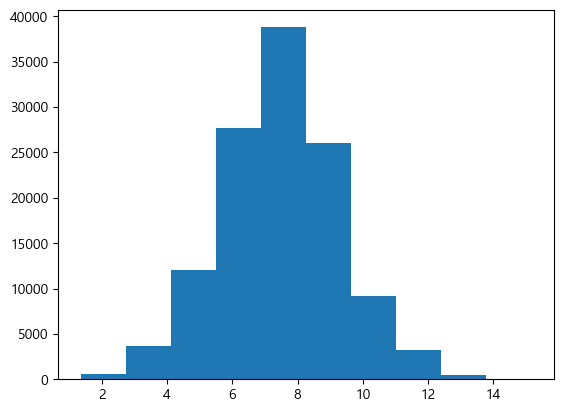

In [15]:
plt.hist(train['마킹길이'])

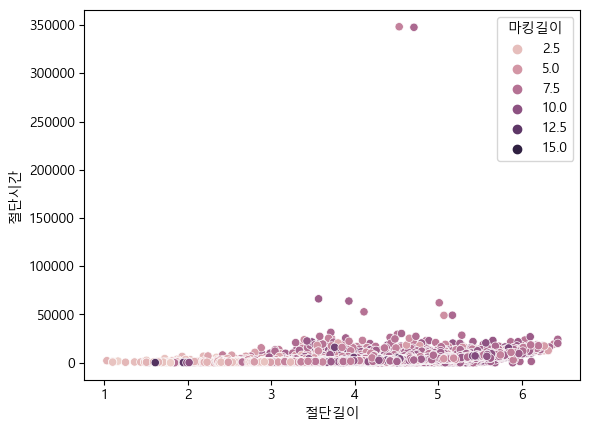

In [16]:
f = sns.scatterplot(x = '절단길이', y = '절단시간', hue = '마킹길이', data = train)

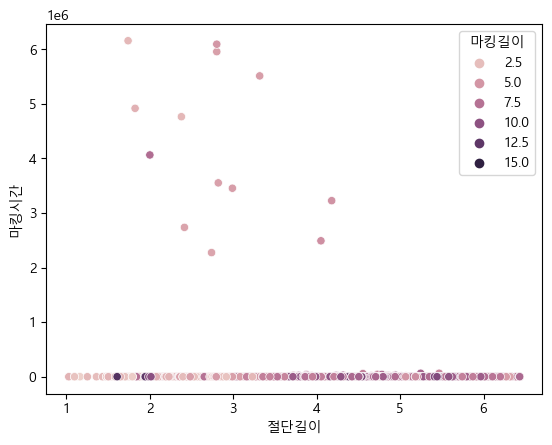

In [17]:
f = sns.scatterplot(x = '절단길이', y = '마킹시간', hue = '마킹길이', data = train)

In [18]:
def remove_outliers(df, col_name):
    uppper_bound = df[col_name].mean() + 5 * df[col_name].std()
    lower_bound = df[col_name].mean() - 5 * df[col_name].std()

    return df[(df[col_name] < uppper_bound) & (df[col_name] > lower_bound)]

columns_to_process = ['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자', '마킹시간', '절단시간']

for col in columns_to_process:
    train = remove_outliers(train, col)

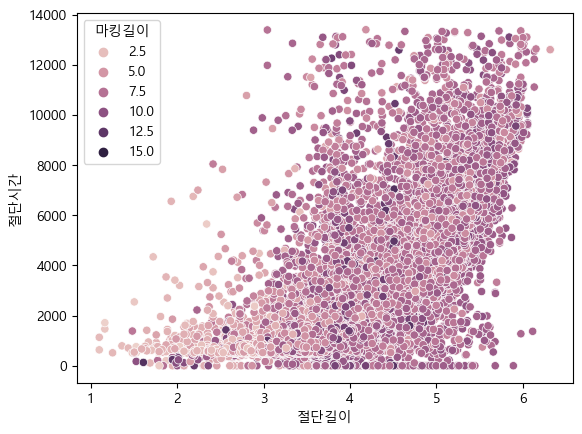

In [19]:
f = sns.scatterplot(x = '절단길이', y = '절단시간', hue = '마킹길이', data = train)

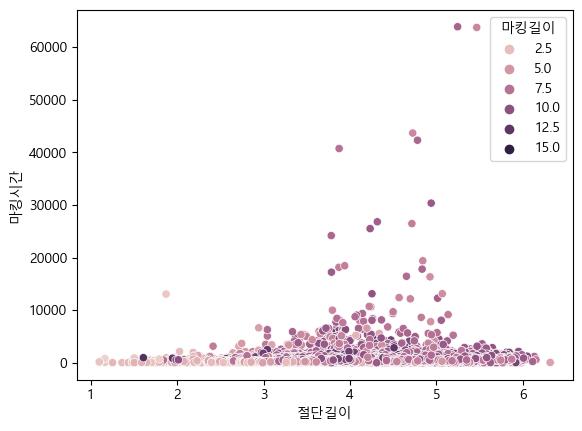

In [20]:
f = sns.scatterplot(x = '절단길이', y = '마킹시간', hue = '마킹길이', data = train)

In [21]:
common_columns = ['작업번호', '마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자']

train_common = train[common_columns]
test_common = test[common_columns]

In [22]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_common)
test_scaled = scaler.transform(test_common)

In [26]:
# X = train_scaled[['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자', '마킹시간', '절단시간']]
# y = train_scaled[['작업자', '마킹시간', '절단시간']]

X = train_scaled[:, 1 : 10]
y = train_scaled[:, 6 : 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
k = 5

kf = KFold(n_splits = k, shuffle = True, random_state = 42)

In [28]:
model = RandomForestRegressor()

In [30]:
mse_scores = []

for train_idx, val_idx, in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_pred)
    mse_scores.append(mse)

print(f'평균 MSE : {np.mean(mse_scores)}')

평균 MSE : 2.218782533445363e-28


In [31]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [39]:
pred = model.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, pred)
print(f'MSE : {mse}')

MSE : 3.468720096411716e-28
